In [7]:
#Import#

from cellpose import models, core, io, plot, train, metrics
import numpy as np
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt

# run this to get printing of progress
io.logger_setup()

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

creating new log file
2025-09-22 14:20:32,106 [INFO] WRITING LOG OUTPUT TO C:\Users\v.aubry\.cellpose\run.log
2025-09-22 14:20:32,106 [INFO] 
cellpose version: 	4.0.7.dev14+gd95f58a66 
platform:       	win32 
python version: 	3.11.13 
torch version:  	2.8.0+cu128
2025-09-22 14:20:32,109 [INFO] ** TORCH CUDA version installed and working. **


In [2]:
#Data#

DAPI_train_dir = r'C:\Users\v.aubry\Desktop\Microscopy_Data\Test_Data\DAPI_Training_Data'
if not Path(DAPI_train_dir).exists():
  raise FileNotFoundError("directory does not exist")
    
DAPI_test_dir = r'C:\Users\v.aubry\Desktop\Microscopy_Data\Test_Data\DAPI_Test_Data'

pred_ext = "_seg.npy"


# list all training files 
files = [f for f in Path(DAPI_train_dir).glob("*") if "_pred" not in f.name and "_flows" not in f.name and "_seg" not in f.name]

if(len(files)==0):
  raise FileNotFoundError("no files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} files in training folder:")

for f in files:
  print(f.name)

# list all testing files 
files = [f for f in Path(DAPI_test_dir).glob("*") if "_pred" not in f.name and "_flows" not in f.name and "_seg" not in f.name]

if(len(files)==0):
  raise FileNotFoundError("no files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} files in testing folder:")

for f in files:
  print(f.name)



5 files in training folder:
ATR1_8h--W00029--P00001--Z00000--T00000--DAPI SEM.tif
ATR1_8h--W00029--P00002--Z00000--T00000--DAPI SEM.tif
ATR1_8h--W00029--P00003--Z00000--T00000--DAPI SEM.tif
ATR1_8h--W00029--P00004--Z00000--T00000--DAPI SEM.tif
ATR1_8h--W00029--P00005--Z00000--T00000--DAPI SEM.tif
3 files in testing folder:
ATR1_8h--W00029--P00006--Z00000--T00000--DAPI SEM.tif
ATR1_8h--W00029--P00007--Z00000--T00000--DAPI SEM.tif
ATR1_8h--W00029--P00008--Z00000--T00000--DAPI SEM.tif


In [4]:
#Model Parameters#
#Threshold#

model = models.CellposeModel(gpu=True)

model_name = "DAPI_model"

# default training params
n_epochs = 10
learning_rate = 1e-5
weight_decay = 0.1
batch_size = 1

# get files
output = io.load_train_test_data(DAPI_train_dir, DAPI_test_dir, mask_filter=pred_ext)
train_data, train_labels, _, test_data, test_labels, _ = output
# (not passing test data into function to speed up training)



# initialize a SAM-based Cellpose model
model = models.CellposeModel(
    gpu=True, 
    pretrained_model="sam",   # this is the important part
    model_type="sam",         # makes sure we use the new architecture
    nchan=2                   # adjust if your data has 2 channels (DAPI + something)
)


2025-09-22 14:17:41,147 [INFO] ** TORCH CUDA version installed and working. **
2025-09-22 14:17:41,149 [INFO] >>>> using GPU (CUDA)
2025-09-22 14:17:43,915 [INFO] >>>> loading model C:\Users\v.aubry\.cellpose\models\cpsam
2025-09-22 14:17:45,337 [INFO] not all flows are present, running flow generation for all images
2025-09-22 14:17:47,751 [INFO] 5 / 5 images in C:\Users\v.aubry\Desktop\Microscopy_Data\Test_Data\DAPI_Training_Data folder have labels
2025-09-22 14:17:47,758 [INFO] not all flows are present, running flow generation for all images
2025-09-22 14:17:49,413 [INFO] 3 / 3 images in C:\Users\v.aubry\Desktop\Microscopy_Data\Test_Data\DAPI_Test_Data folder have labels
2025-09-22 14:17:49,415 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-09-22 14:17:49,416 [WARNING] nchan argument is deprecated in v4.0.1+. Ignoring this argument
2025-09-22 14:17:49,419 [INFO] ** TORCH CUDA version installed and working. **
2025-09-22 14:17:49,421 [INFO] >>>>

In [5]:
#Model Training#
#check if __ is fine as replacement for variable

new_model_path, train_losses, __ = train.train_seg(model.net,
                                                            train_data=train_data,
                                                            train_labels=train_labels,
                                                            batch_size=batch_size,
                                                            n_epochs=n_epochs,
                                                            learning_rate=learning_rate,
                                                            weight_decay=weight_decay,
                                                            nimg_per_epoch=max(2, len(train_data)), # can change this
                                                            model_name=model_name)

2025-09-22 14:18:12,532 [INFO] computing flows for labels


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.64it/s]

2025-09-22 14:18:15,654 [INFO] >>> computing diameters



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.33it/s]

2025-09-22 14:18:15,808 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2025-09-22 14:18:16,710 [INFO] >>> n_epochs=10, n_train=5, n_test=None
2025-09-22 14:18:16,712 [INFO] >>> AdamW, learning_rate=0.00001, weight_decay=0.10000
2025-09-22 14:18:16,715 [INFO] >>> saving model to C:\Users\v.aubry\Desktop\Microscopy_Data\Jupyter_Notebook\models\DAPI_model
2025-09-22 14:18:21,924 [INFO] 0, train_loss=0.0089, test_loss=0.0000, LR=0.000000, time 5.21s
2025-09-22 14:18:35,312 [INFO] 5, train_loss=0.0312, test_loss=0.0000, LR=0.000006, time 18.60s
2025-09-22 14:18:46,495 [INFO] saving network parameters to C:\Users\v.aubry\Desktop\Microscopy_Data\Jupyter_Notebook\models\DAPI_model


In [12]:
#Model Testing#
#Mask --> pred variable change (also change all variables to make it more readable)

model = models.CellposeModel(gpu=True,
                             pretrained_model=new_model_path)

# run model on test images
pred = model.eval(test_data, batch_size=5)[0]  #Batchsize is number of pictures in Training Data Set (5 for now)

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, pred)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')

2025-09-22 14:41:39,004 [INFO] ** TORCH CUDA version installed and working. **
2025-09-22 14:41:39,006 [INFO] >>>> using GPU (CUDA)
2025-09-22 14:41:41,726 [INFO] >>>> loading model C:\Users\v.aubry\Desktop\Microscopy_Data\Jupyter_Notebook\models\DAPI_model
2025-09-22 14:42:26,339 [INFO] 100%|##########| 3/3 [00:43<00:00, 14.64s/it]

>>> average precision at iou threshold 0.5 = 0.831


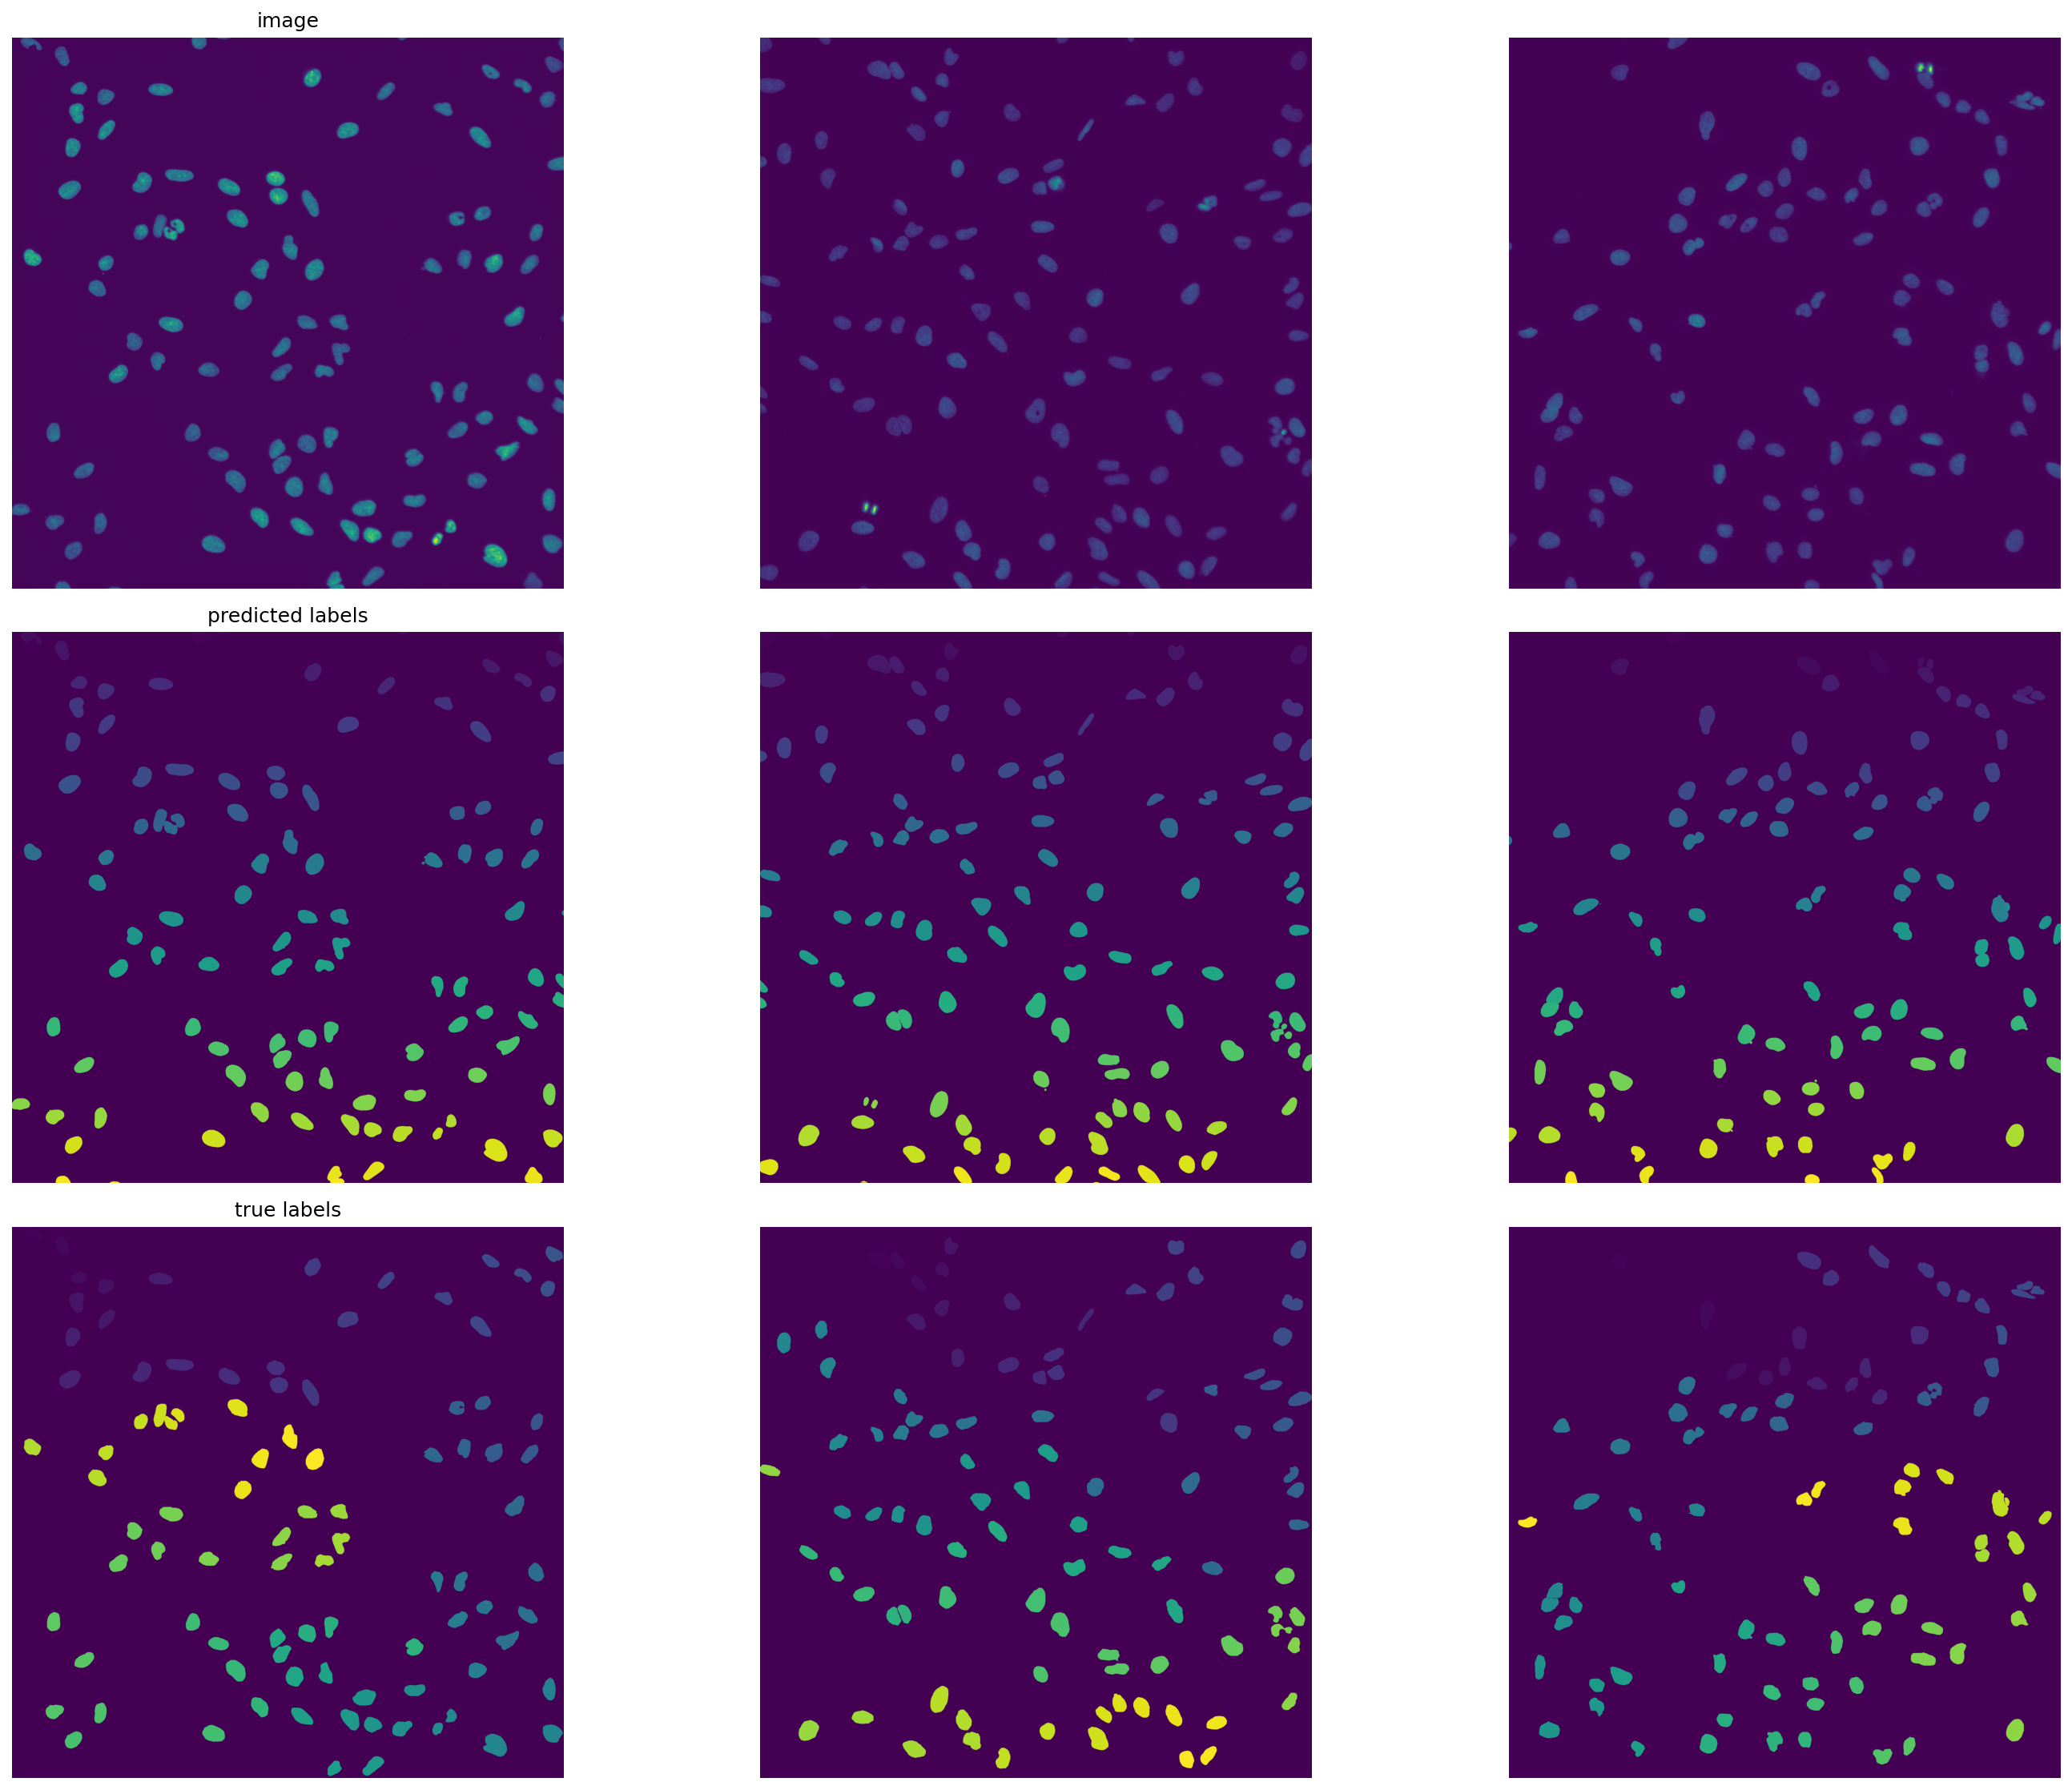

In [9]:
#Plotting#

plt.figure(figsize=(20,15), dpi=150) # Adjusted figure size and DPI
for k,im in enumerate(test_data):
    img = im.copy()
    plt.subplot(3,len(test_data), k+1)
    # Check image dimensions and adjust for plotting
    if img.ndim == 2:
        # Grayscale image [H x W], display directly
        pass # img is already [H x W]
    elif img.ndim == 3:
        # Color or multichannel image [C x H x W], transpose to [H x W x C]
        img = img.transpose(1, 2, 0)
    else:
        # Handle other dimensions if necessary, or skip
        print(f"Skipping image {k} with unexpected dimensions: {img.shape}")
        continue

    plt.imshow(img)
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(test_data), len(test_data) + k+1)
    # Assuming pred are [H x W]
    plt.imshow(pred[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(test_data), 2*len(test_data) + k+1)
    # Assuming true labels are [H x W]
    plt.imshow(test_labels[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()

In [ ]:
######################################################################

In [ ]:
######################################################################

In [ ]:
######################################################################

In [7]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

creating new log file
2025-09-18 14:29:35,513 [INFO] WRITING LOG OUTPUT TO C:\Users\v.aubry\.cellpose\run.log
2025-09-18 14:29:35,514 [INFO] 
cellpose version: 	4.0.7.dev14+gd95f58a66 
platform:       	win32 
python version: 	3.11.13 
torch version:  	2.8.0+cu128
2025-09-18 14:29:35,954 [INFO] ** TORCH CUDA version installed and working. **


In [8]:
DAPI_train_dir = r'C:\Users\v.aubry\Desktop\Microscopy_Data\Test_Data\DAPI_Training_Data'
if not Path(DAPI_train_dir).exists():
  raise FileNotFoundError("directory does not exist")
DAPI_test_dir = r'C:\Users\v.aubry\Desktop\Microscopy_Data\Test_Data\DAPI_Test_Data'

masks_ext = "_seg.npy"

# list all files
files = [f for f in Path(DAPI_train_dir).glob("*") if "_masks" not in f.name and "_flows" not in f.name and "_seg" not in f.name]

if(len(files)==0):
  raise FileNotFoundError("no files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} files in folder:")

for f in files:
  print(f.name)

5 files in folder:
ATR1_8h--W00029--P00001--Z00000--T00000--DAPI SEM.tif
ATR1_8h--W00029--P00002--Z00000--T00000--DAPI SEM.tif
ATR1_8h--W00029--P00003--Z00000--T00000--DAPI SEM.tif
ATR1_8h--W00029--P00004--Z00000--T00000--DAPI SEM.tif
ATR1_8h--W00029--P00005--Z00000--T00000--DAPI SEM.tif


In [9]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

creating new log file
2025-09-18 14:29:37,504 [INFO] WRITING LOG OUTPUT TO C:\Users\v.aubry\.cellpose\run.log
2025-09-18 14:29:37,504 [INFO] 
cellpose version: 	4.0.7.dev14+gd95f58a66 
platform:       	win32 
python version: 	3.11.13 
torch version:  	2.8.0+cu128
2025-09-18 14:29:37,506 [INFO] ** TORCH CUDA version installed and working. **
2025-09-18 14:29:37,508 [INFO] ** TORCH CUDA version installed and working. **
2025-09-18 14:29:37,509 [INFO] >>>> using GPU (CUDA)
2025-09-18 14:29:40,889 [INFO] >>>> loading model C:\Users\v.aubry\.cellpose\models\cpsam


In [11]:
from cellpose import train

model_name = "new_model"

# default training params
n_epochs = 10
learning_rate = 1e-5
weight_decay = 0.1
batch_size = 1

# get files
output = io.load_train_test_data(DAPI_train_dir, DAPI_test_dir, mask_filter=masks_ext)
train_data, train_labels, _, test_data, test_labels, _ = output
# (not passing test data into function to speed up training)



# initialize a SAM-based Cellpose model
model = models.CellposeModel(
    gpu=True, 
    pretrained_model="sam",   # this is the important part
    model_type="sam",         # makes sure we use the new architecture
    nchan=2                   # adjust if your data has 2 channels (DAPI + something)
)


new_model_path, train_losses, __ = train.train_seg(model.net,
                                                            train_data=train_data,
                                                            train_labels=train_labels,
                                                            batch_size=batch_size,
                                                            n_epochs=n_epochs,
                                                            learning_rate=learning_rate,
                                                            weight_decay=weight_decay,
                                                            nimg_per_epoch=max(2, len(train_data)), # can change this
                                                            model_name=model_name)


2025-09-18 14:39:09,088 [INFO] not all flows are present, running flow generation for all images
2025-09-18 14:39:09,200 [INFO] 5 / 5 images in C:\Users\v.aubry\Desktop\Microscopy_Data\Test_Data\DAPI_Training_Data folder have labels
2025-09-18 14:39:09,207 [INFO] not all flows are present, running flow generation for all images
2025-09-18 14:39:09,280 [INFO] 3 / 3 images in C:\Users\v.aubry\Desktop\Microscopy_Data\Test_Data\DAPI_Test_Data folder have labels
2025-09-18 14:39:09,299 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-09-18 14:39:09,300 [WARNING] nchan argument is deprecated in v4.0.1+. Ignoring this argument
2025-09-18 14:39:09,308 [INFO] ** TORCH CUDA version installed and working. **
2025-09-18 14:39:09,309 [INFO] >>>> using GPU (CUDA)
2025-09-18 14:39:09,311 [WARNING] pretrained model C:\Users\v.aubry\.cellpose\models\cpsam not found, using default model
2025-09-18 14:39:12,071 [INFO] >>>> loading model C:\Users\v.aubry\.cellpose\model

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]

2025-09-18 14:39:16,028 [INFO] >>> computing diameters



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.50it/s]

2025-09-18 14:39:16,170 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2025-09-18 14:39:17,058 [INFO] >>> n_epochs=100, n_train=5, n_test=None
2025-09-18 14:39:17,059 [INFO] >>> AdamW, learning_rate=0.00001, weight_decay=0.10000
2025-09-18 14:39:17,062 [INFO] >>> saving model to C:\Users\v.aubry\Desktop\Microscopy_Data\Jupyter_Notebook\models\new_model
2025-09-18 14:39:25,836 [INFO] 0, train_loss=0.0087, test_loss=0.0000, LR=0.000000, time 8.78s
2025-09-18 14:39:41,125 [INFO] 5, train_loss=0.0317, test_loss=0.0000, LR=0.000006, time 24.06s
2025-09-18 14:39:57,366 [INFO] 10, train_loss=0.0189, test_loss=0.0000, LR=0.000010, time 40.31s
2025-09-18 14:40:29,487 [INFO] 20, train_loss=0.0243, test_loss=0.0000, LR=0.000010, time 72.43s
2025-09-18 14:41:02,919 [INFO] 30, train_loss=0.0282, test_loss=0.0000, LR=0.000010, time 105.86s
2025-09-18 14:41:35,288 [INFO] 40, train_loss=0.0500, test_loss=0.0000, LR=0.000010, time 138.23s
2025-09-18 14:42:06,680 [INFO] 50, train_loss=0.0580, test_loss=0.0000, LR=0.000005, time 169.62s
2025-09-18 14:42:38,276 [INFO] 60, tr

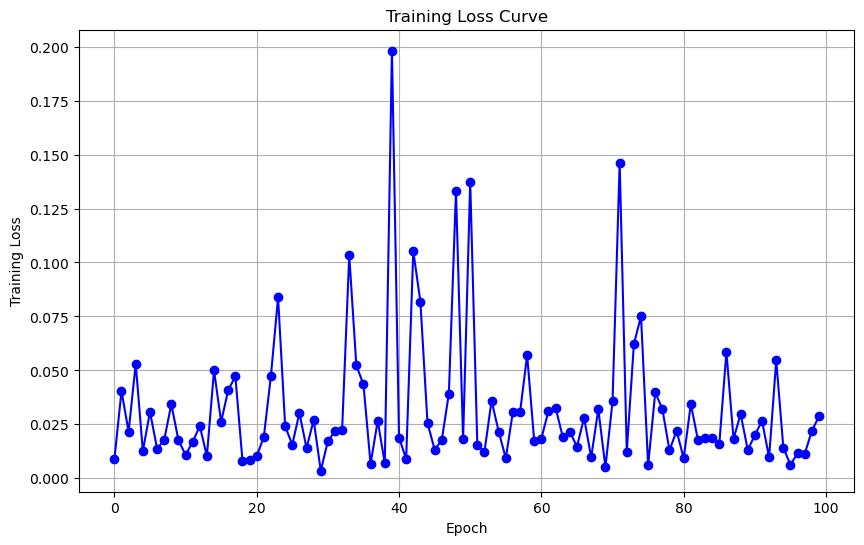

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

In [12]:
from cellpose import metrics

model = models.CellposeModel(gpu=True,
                             pretrained_model=new_model_path)

# run model on test images
pred = model.eval(test_data, batch_size=1)[0]  #reduced batchsize from 32!!!!!!!!

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, pred)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')

2025-09-18 14:44:57,468 [INFO] ** TORCH CUDA version installed and working. **
2025-09-18 14:44:57,469 [INFO] >>>> using GPU (CUDA)
2025-09-18 14:45:02,981 [INFO] >>>> loading model C:\Users\v.aubry\Desktop\Microscopy_Data\Jupyter_Notebook\models\new_model
2025-09-18 14:46:09,811 [INFO] 100%|##########| 3/3 [01:06<00:00, 22.05s/it]

>>> average precision at iou threshold 0.5 = 0.856


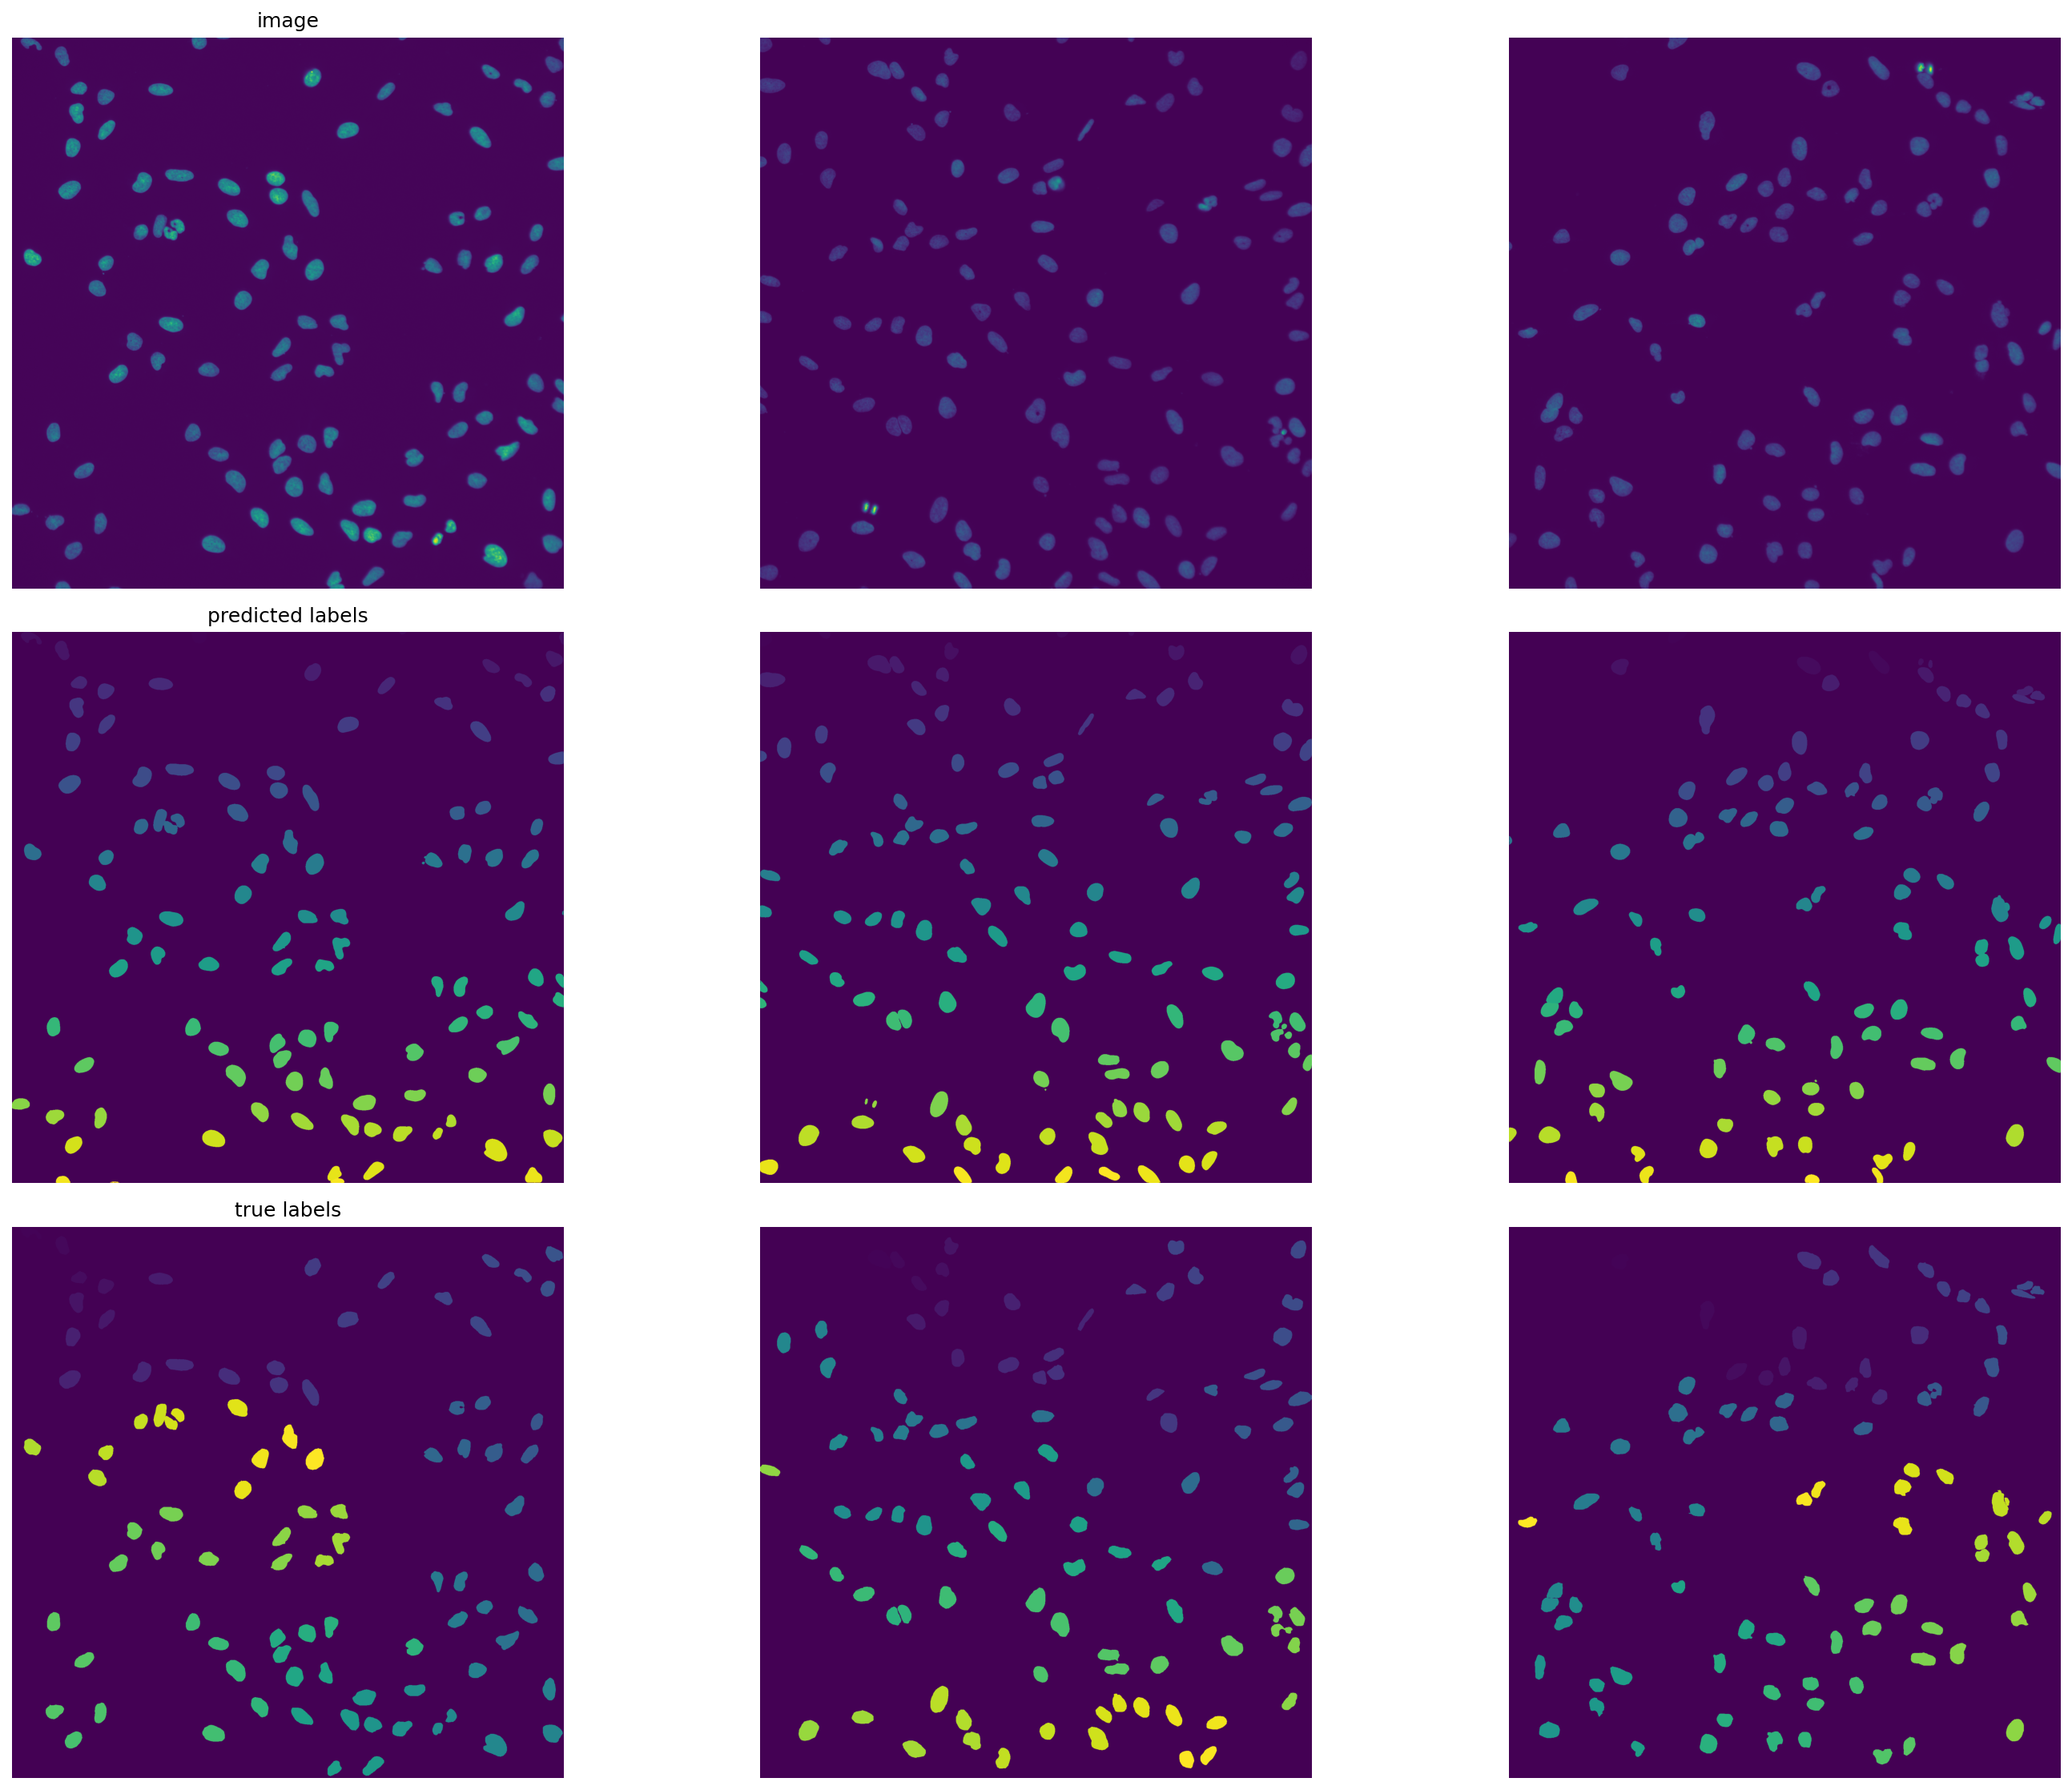

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15), dpi=150) # Adjusted figure size and DPI
for k,im in enumerate(test_data):
    img = im.copy()
    plt.subplot(3,len(test_data), k+1)
    # Check image dimensions and adjust for plotting
    if img.ndim == 2:
        # Grayscale image [H x W], display directly
        pass # img is already [H x W]
    elif img.ndim == 3:
        # Color or multichannel image [C x H x W], transpose to [H x W x C]
        img = img.transpose(1, 2, 0)
    else:
        # Handle other dimensions if necessary, or skip
        print(f"Skipping image {k} with unexpected dimensions: {img.shape}")
        continue

    plt.imshow(img)
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(test_data), len(test_data) + k+1)
    # Assuming masks are [H x W]
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(test_data), 2*len(test_data) + k+1)
    # Assuming true labels are [H x W]
    plt.imshow(test_labels[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()